In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


data = pd.read_csv('./takeoff-merged-VQ-BGU-30s.csv', parse_dates=['reportts']) \
  .sort_values('reportts')

data = data[data['pos'] == 1]

y = data['egtm']

X = data.drop(columns=[
    'acnum', 'pos', 'dep', 'arr', 
    'egtm', 'fltdes', 'reportts',
    'dmusw', 'exswpn', 'reason'
]).fillna(0)

X = X.loc[:, ~X.columns.str.contains('stw')]

In [2]:
def fahrenheit_to_cels(series):
    return (series - 32) * (5.0/9.0)

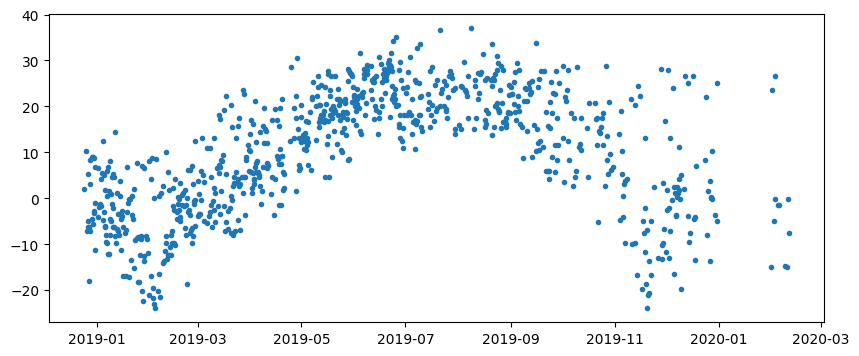

In [3]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.plot(data['reportts'], data['tat'], '.')
# ax.plot(data['reportts'], data['tatc'], '.')
plt.show()

Из графика видно, что tat скорее всего измеряется в градусах Цельсия, а не в Фаренгейтах.

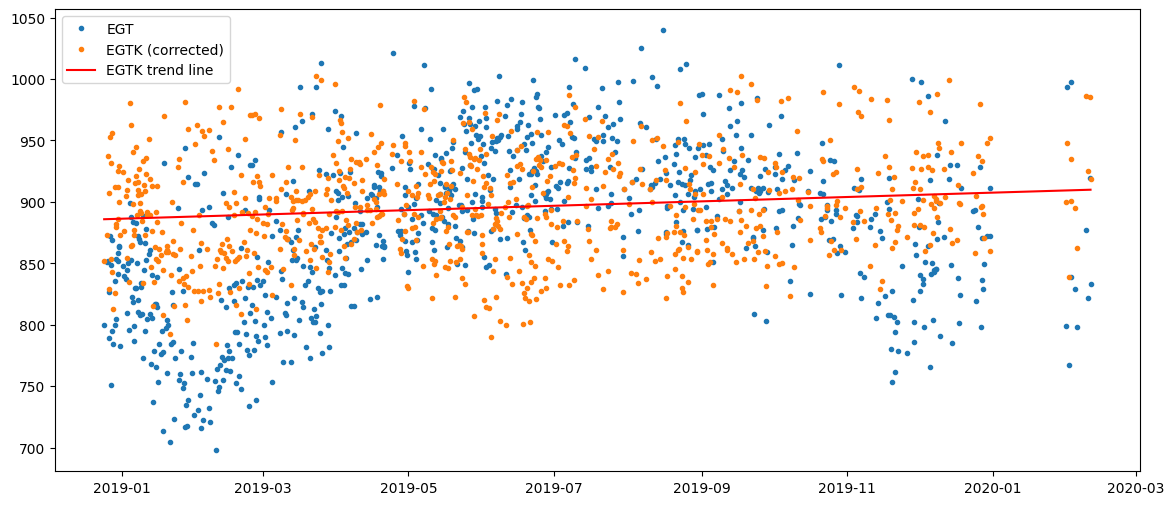

In [43]:
fig, ax = plt.subplots(1, 1, figsize=(14, 6))
data['theta'] = (data['tat'] + 273.15) / 288.15

data['beta'] = 1 + (data['tat'] / data['nf'])

data['egtk'] = (data['egt'] + 273.15) / (data['theta'] ** data['beta'] ) - 273.15
z = np.polyfit(data['reportts'].astype(int) / 10**9, data['egtk'], 1)
p = np.poly1d(z)

ax.plot(data['reportts'], data['egt'], '.')
ax.plot(data['reportts'], data['egtk'], '.')
ax.plot(data['reportts'], p(data['reportts'].astype(int) / 10**9), color='r')
ax.legend(['EGT', 'EGTK (corrected)', 'EGTK trend line'])
plt.show()

In [45]:
(data['tat'] / data['nf']).describe()

count    835.000000
mean       0.115590
std        0.156649
min       -0.312297
25%       -0.002345
50%        0.139699
75%        0.240843
max        0.431588
dtype: float64

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(14, 6))

data['egt_redline'] = data['egtm'] + data['egtk']

ax.plot(data['reportts'], data['egt_redline'], '.')
ax.legend(['EGT redline'])
# plt.show()

In [7]:
data['egt_redline'].describe()

count     835.000000
mean      930.186204
std        39.144901
min       835.371066
25%       902.087075
50%       926.904917
75%       957.479255
max      1032.183876
Name: egt_redline, dtype: float64

In [8]:
from sklearn.model_selection import cross_val_predict, train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor

In [52]:
def train_model(X, y):
    assert len(X) == len(y)
    train_i = int(len(X) * 60 / 100)
    X_train, y_train = X[0:train_i], y[0:train_i]
    X_test, y_test = X[train_i:], y[train_i:]

    # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=43)
    scaler = StandardScaler()

    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    model = GradientBoostingRegressor()
    model.fit(X_train, y_train)

    predicted = model.predict(X_test)
    mse = mean_squared_error(y_test, predicted, squared=False)
    mae = mean_absolute_error(y_test, predicted)

    return mse, mae, model

In [32]:
adj_features = [
  'hpcbf', 'ff', 'nait', 'fmvc', 'tn', 'p2e', 'sva', 'lpbt', 'gle', 'tfuel', 'tat', 
  'ffr', 'n1p', 'cas', 'vorrc', 'n2c5', 'joip', 'lpt', 'n2a', 'hpctc', 'n2p', 'lpcsv', 'pf', 
  'gw', 'n1c2', 'ttp', 'ps14', 'nai', 'fvd', 'lpctc', 'foc', 'cg', 'w14'
]

In [53]:
mse, mae, model = train_model(X[adj_features], data['egt_redline'])

mse, mae

(10.722262026860154, 8.514419661476808)

In [ ]:
X2 = X[adj_features]
X2['egtk'] = data['egtk']
train_model(X2, data['egtm'])

In [16]:

y = data['egt_redline']

model = GradientBoostingRegressor()
preds = cross_val_predict(model, X[adj_features], y)
rmse = mean_squared_error(y, preds, squared=False)
mae = mean_absolute_error(y, preds)


In [17]:
rmse, mae

(10.866273884409186, 8.13695372006734)

In [13]:
# fig, ax = plt.subplots(1, 1, figsize=(14, 6))
# data['egtc'] = cels_to_fahrenheit(data['egt'])
# data['tatc'] = cels_to_fahrenheit(data['tat'])
# data['theta2'] = (data['tatc'] + 273.15) / 288.15
# data['egtk'] = (data['egtc'] + 273.15) / (data['theta2'] ** 1)
# z = np.polyfit(data['reportts'].astype(int) / 10**9, data['egtk'], 1)
# p = np.poly1d(z)
# ax.plot(data['reportts'], data['egt'], '.')
# ax.plot(data['reportts'], data['egtk'], '.')
# plt.show()